# Settings

In [110]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt   

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
sns.set(rc={'figure.figsize':(12, 6)})

sns.set_style("whitegrid")

# Function plot()

In [112]:
def plot(train, test, fittedvalues, forecast, methodname):
    
    fig, axs = plt.subplots(1,2,figsize=(16,6), sharey=True,gridspec_kw={"width_ratios": (.55, .45)})
        
    fittedvalues.plot(color='green', ax=axs[0], label='Fitted Values')
    train.plot(color='grey', ax=axs[0], label ='Given Train Data')
    
    r2 = np.round(r2_score(train, fittedvalues),2)
    mae = np.round(mean_absolute_error(train, fittedvalues),2)
    mse = np.round(mean_squared_error(train, fittedvalues),2)
    axs[0].set_title(f'Fitted Values\nR2={r2}, MAE={mae}, MSE={mse}', fontsize=14)
    axs[0].legend()

    
    test.plot(color='blue', ax=axs[1], label='Given Test Data')
    forecast.plot(color='red', ax=axs[1], label='Forecast')
                     
    r2 = np.round(r2_score(test, forecast),2)
    mae = np.round(mean_absolute_error(test, forecast),2)
    mse = np.round(mean_squared_error(test, forecast),2)
    axs[1].set_title(f'Forecast\nR2={r2}, MAE={mae}, MSE={mse}', fontsize=14)
    axs[1].legend()
    
    plt.suptitle(f'Method: {methodname}\n')
    plt.tight_layout();

# Dataset

In [113]:
df = pd.read_csv(r"C:\Users\user\Documents\DataAnalyse\TimeSeriasForecasting\Datasets\monthly-car-sales.csv")

In [114]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [115]:
df.tail()

,Month,Sales
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180
107,1968-12,14577


Let's create a series with Month as the index and Sales as the value

In [116]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
s = df['Sales']
s.index.freq = 'MS'


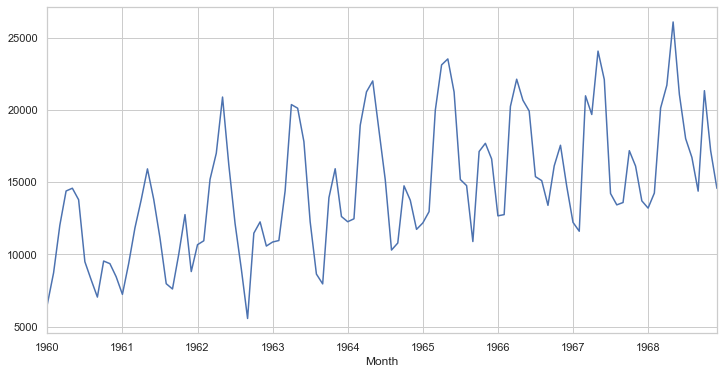

In [117]:
s.plot();

**According to the visual assessment of the plot - the model is most likely addictive**

In [118]:
s.shape

(108,)

# seasonal_decompose

In [119]:
decompose_result = seasonal_decompose(s,model='additive')
trend, seasonal, resid = decompose_result.trend, decompose_result.seasonal, decompose_result.resid

list_to_plot =[trend, seasonal, resid]

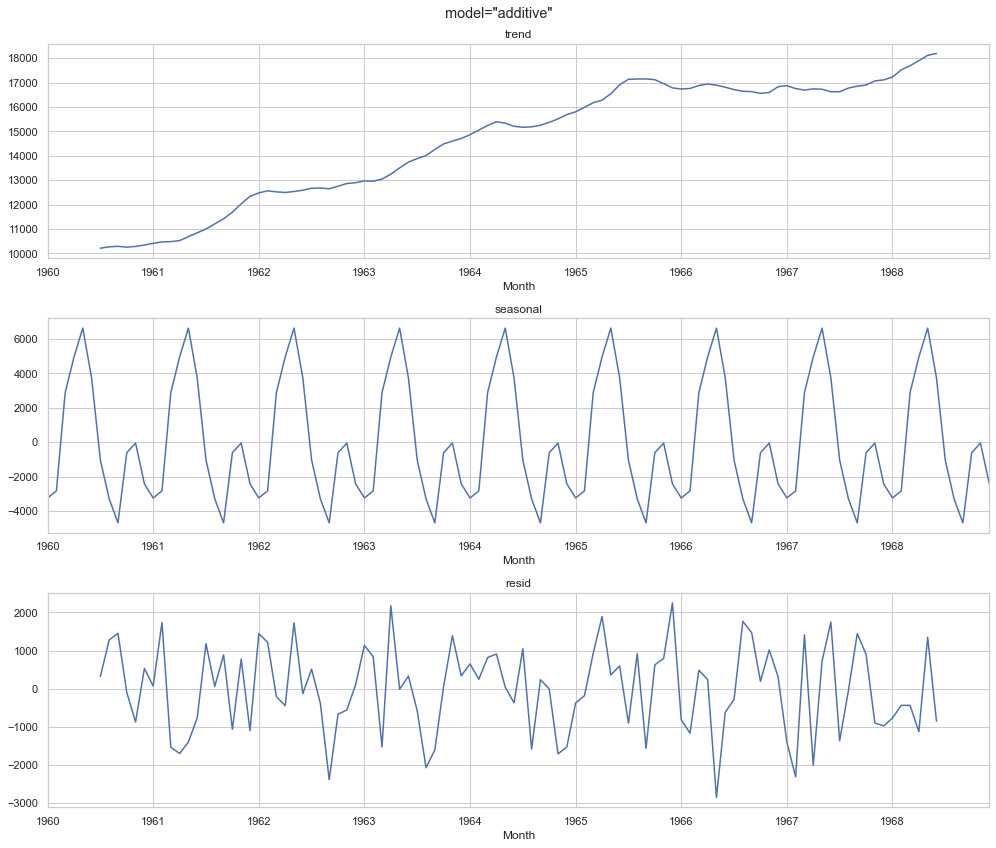

In [120]:
fig, axs = plt.subplots(3,1, figsize=(14,12))

for i,ax in enumerate(axs.flatten()):
    
    list_to_plot[i].plot(title=list_to_plot[i].name, ax=ax)
plt.suptitle('model="additive"')
plt.tight_layout();

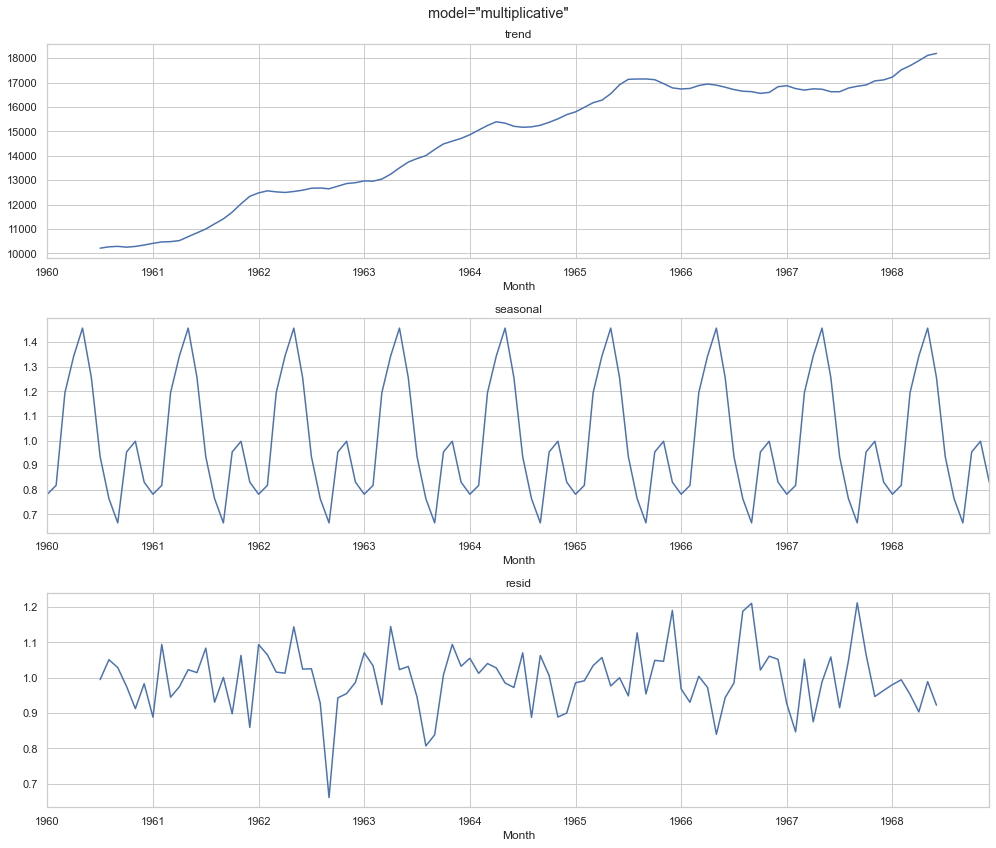

In [121]:
decompose_result = seasonal_decompose(s,model='multiplicative')

trend, seasonal, resid = decompose_result.trend, decompose_result.seasonal, decompose_result.resid

list_to_plot =[trend, seasonal, resid]

fig, axs = plt.subplots(3,1, figsize=(14,12))

for i,ax in enumerate(axs.flatten()):
    
    list_to_plot[i].plot(title=list_to_plot[i].name, ax=ax)
plt.suptitle('model="multiplicative"')
plt.tight_layout()

<mark> Residual error by **multiplicative** model is better</mark>

# Task 1 :: split train and test sets


- Split the data into train and test, leaving two years for test

In [181]:
train, test = s[:-24], s[-24:]

In [182]:
print(f'Size of train set = {train.shape}')
print(f'Size of test set = {test.shape}')


Size of train set = (84,)
Size of test set = (24,)


# Task 2 :: SimpleExpSmoothing

- Create a SimpleExpSmoothing model 
- Train it on the train data
- Make predictions for both train and test
- Select metrics and calculate the quality of predictions for both train and test
- Plot graphs with both real data and predictions

In [124]:
mod=SimpleExpSmoothing(train).fit(optimized=True)#.fittedvalues
mod.summary()

Dep. Variable:,Sales,No. Observations:,84
Model:,SimpleExpSmoothing,SSE,802915829.697
Optimized:,True,AIC,1354.127
Trend:,None,BIC,1358.989
Seasonal:,None,AICC,1354.634
Seasonal Periods:,None,Date:,"Mon, 27 Jun 2022"
Box-Cox:,False,Time:,18:47:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,6550.0000,l.0,True


In [125]:
mod_values = mod.fittedvalues 

In [126]:
train_new = train.copy()
preds = []

for i in range(len(test)):
    model = SimpleExpSmoothing(train_new)
    preds.append(model.fit(optimized=True).forecast(1).values[0])
    train_new = pd.concat([train_new,test[i:i+1]])


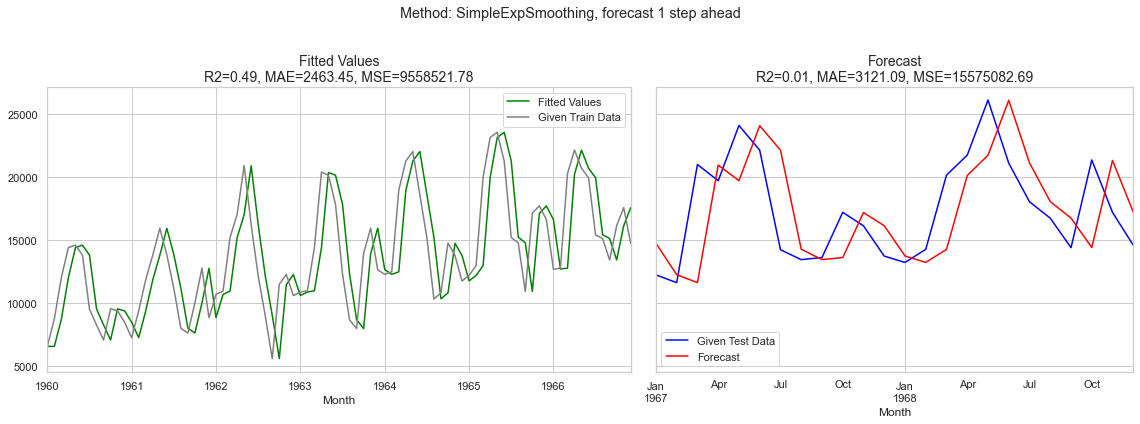

In [127]:
s_pred = pd.Series(preds,test.index)
plot(train,test, mod_values, s_pred, methodname='SimpleExpSmoothing, forecast 1 step ahead')


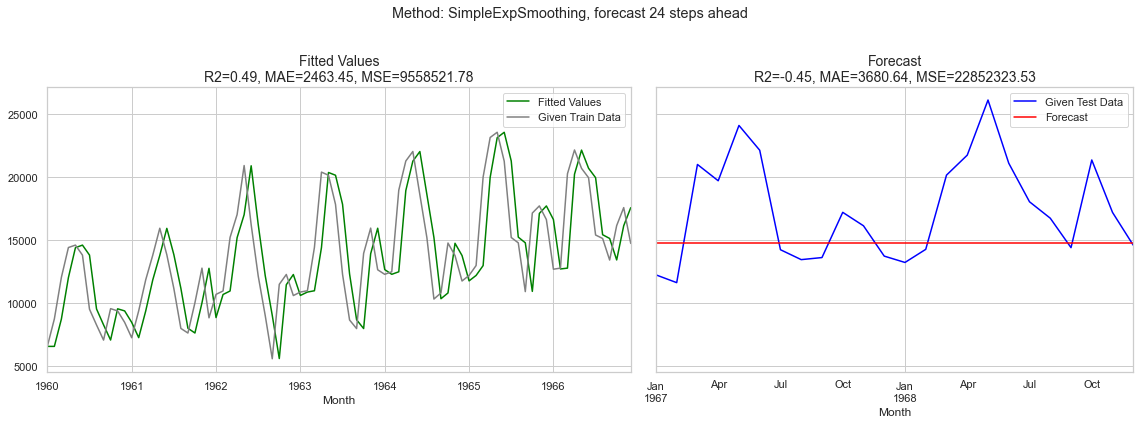

In [128]:
preds = SimpleExpSmoothing(train).fit(optimized=True).forecast(24)

plot(train, test,mod_values, preds, methodname='SimpleExpSmoothing, forecast 24 steps ahead' )

# Task 3 :: Double and Triple Exponential Smoothing

- Build models of double and triple exponential smoothing
- Calculate the metrics for train and test in the same way as in the previous task
- Plot graph

## Holt’s Method (double Exp. Smothing)

In [129]:
holt_mod=Holt(train).fit(optimized=True)
holt_mod.summary()

Dep. Variable:,Sales,No. Observations:,84
Model:,Holt,SSE,879508233.947
Optimized:,True,AIC,1365.781
Trend:,Additive,BIC,1375.504
Seasonal:,None,AICC,1366.872
Seasonal Periods:,None,Date:,"Mon, 27 Jun 2022"
Box-Cox:,False,Time:,18:47:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0473810,beta,True


In [130]:
holt_mod_values = holt_mod.fittedvalues

In [131]:
preds = holt_mod.forecast(24)

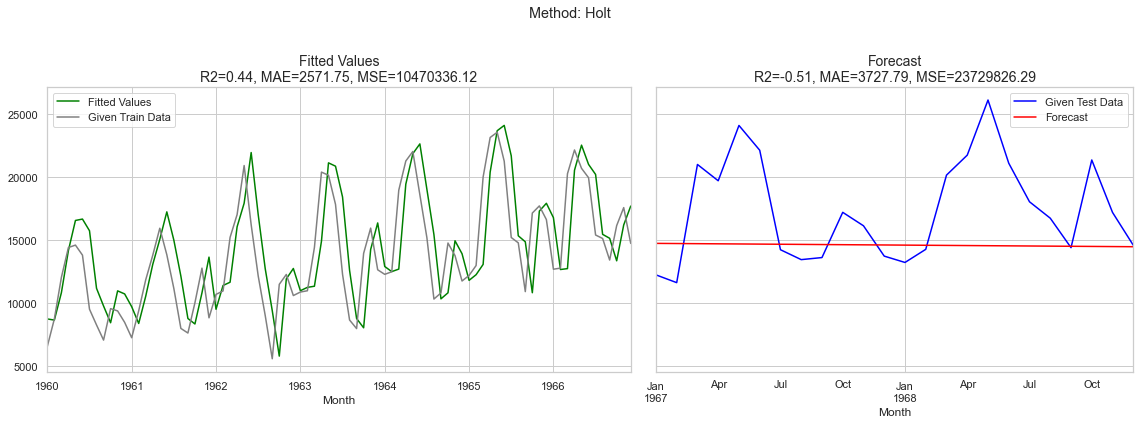

In [132]:
plot(train, test, holt_mod_values, preds, methodname='Holt')

## Holt-Winter Method (triple Exp.Smothing)

In [159]:
holt_winter_mod=ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(optimized=True)
holt_winter_mod.summary()

Dep. Variable:,Sales,No. Observations:,84
Model:,ExponentialSmoothing,SSE,153880414.123
Optimized:,True,AIC,1243.353
Trend:,Additive,BIC,1282.246
Seasonal:,Multiplicative,AICC,1253.876
Seasonal Periods:,12,Date:,"Mon, 27 Jun 2022"
Box-Cox:,False,Time:,19:04:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3232143,alpha,True
smoothing_trend,0.0001,beta,True


In [160]:
holt_winter_mod_values = holt_winter_mod.fittedvalues
preds = holt_winter_mod.forecast(24)

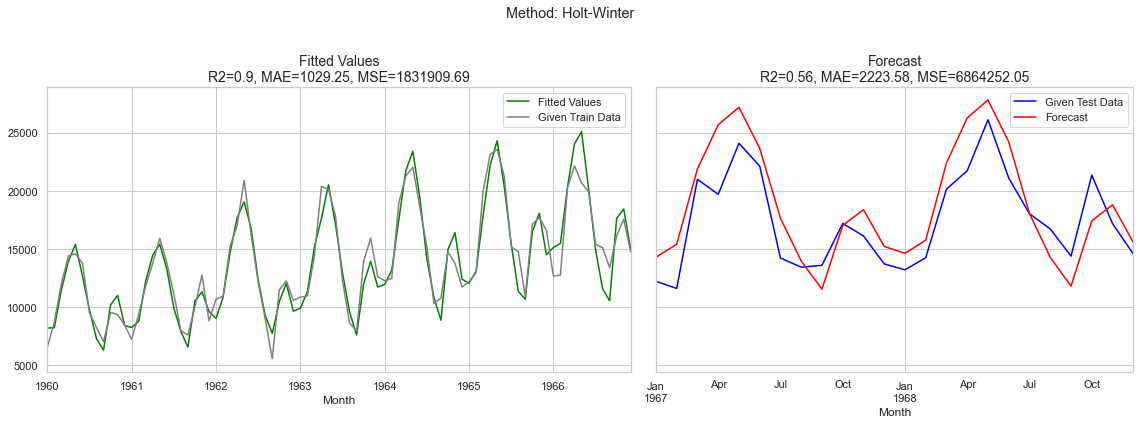

In [161]:
plot(train, test,holt_winter_mod_values, preds, methodname='Holt-Winter')

### Grid Search 

In [183]:
trend_list =['add','mul']
seasonal_list =['add','mul']

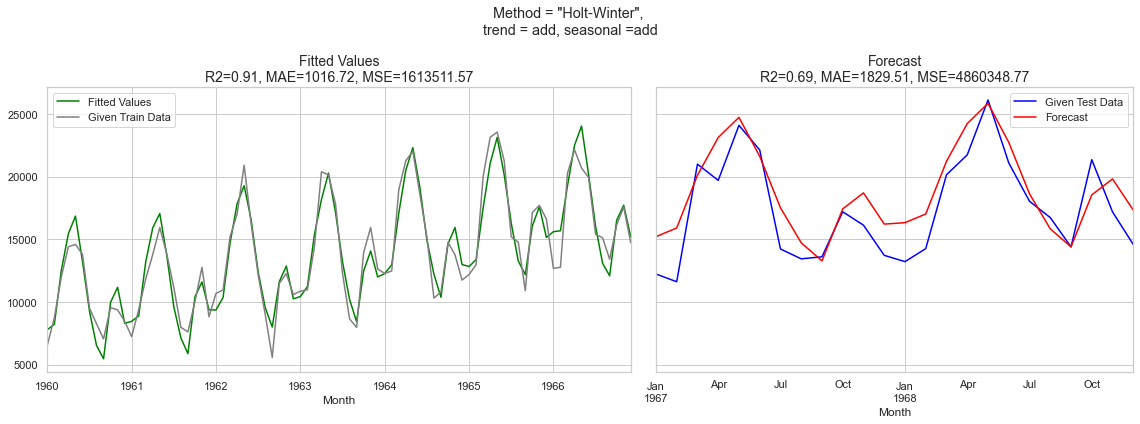

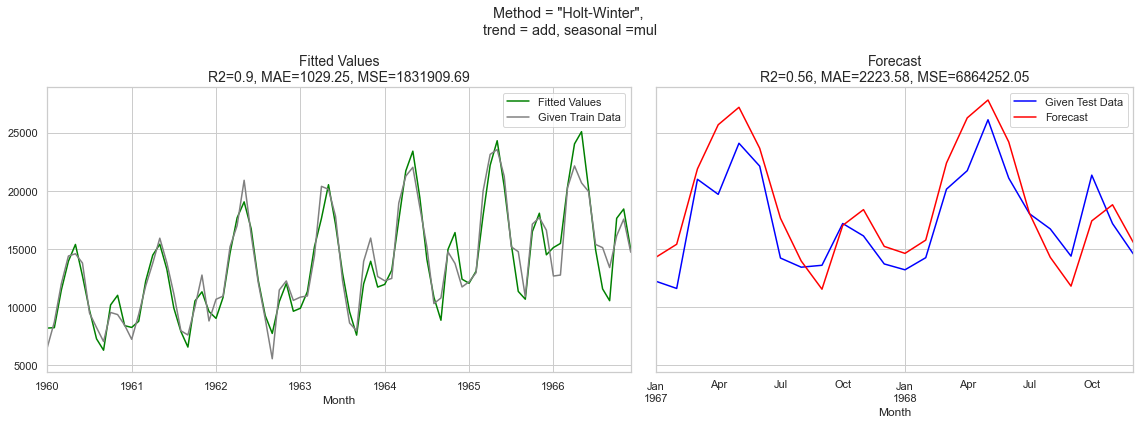

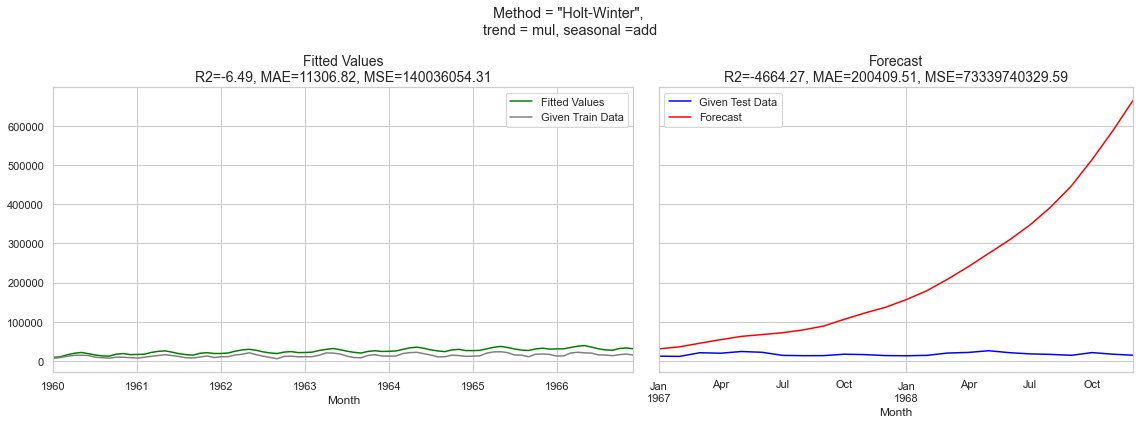

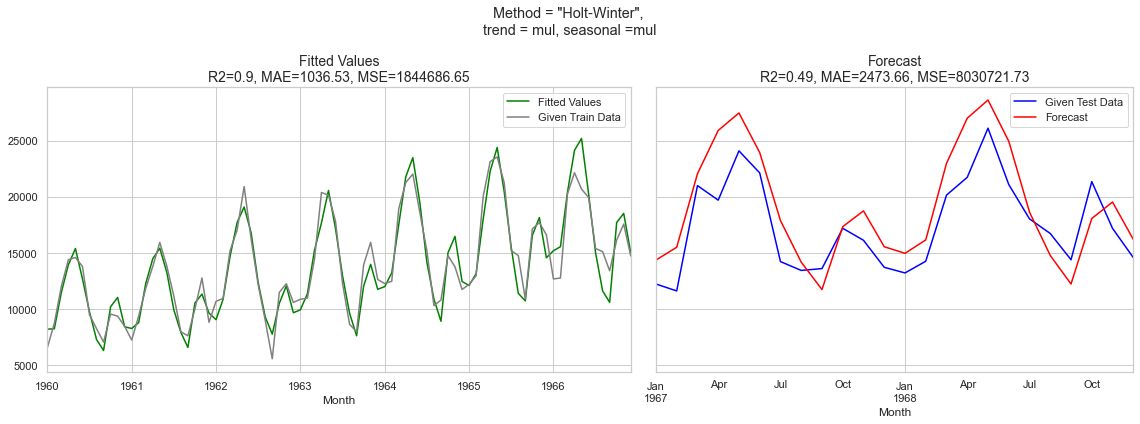

In [187]:
r2_list = []
mae_list = []

for trend in trend_list:
    for seasonal in seasonal_list:

        holt_winter_mod=ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=12).fit(optimized=True)
        holt_winter_mod_values = holt_winter_mod.fittedvalues
        preds = holt_winter_mod.forecast(24)

        r2_list.append(r2_score(test, preds))
        mae_list.append(mean_absolute_error(test, preds))

        plot(train, test,holt_winter_mod_values, preds, methodname='Holt-Winter')
        plt.suptitle(f'Method = "Holt-Winter", \ntrend = {trend}, seasonal ={seasonal}')

# Task 4 :: Cross-Validation


- Select the model with the most suitable parameters among the previous ones
- Make a cross-validation cycle, where the test size is equal to one year
- Calculate the average value of selected metrics

<mark>The best result was shown by the model **Holt-Winter** with parameters:</mark>
    
  - trend = 'add' 
  - seasonal = 'add'

In [188]:
holt_winter_mod=ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
holt_winter_mod_values = holt_winter_mod.fittedvalues
preds = holt_winter_mod.forecast(24)

r2 = r2_score(test,preds)
mae = mean_absolute_error(test, preds)

print(f'r2 = {r2:.2f}, mae= {mae:.2f}')

r2 = 0.69, mae= 1829.51


In [148]:
test_size = 12
n_splits = 4 

size = len(df)

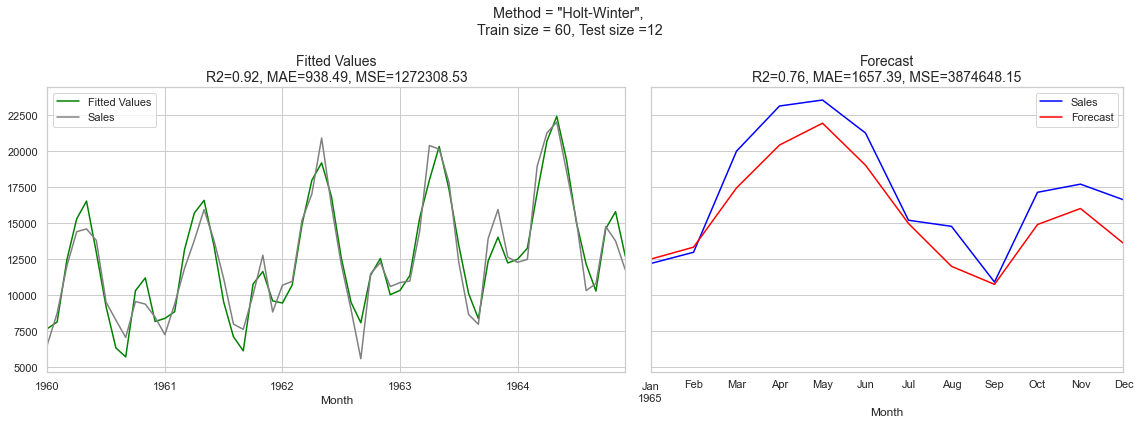

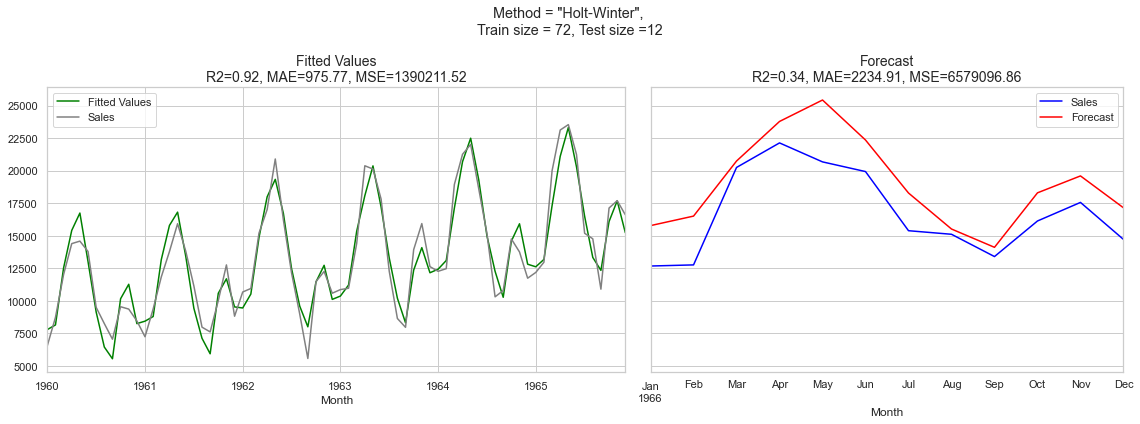

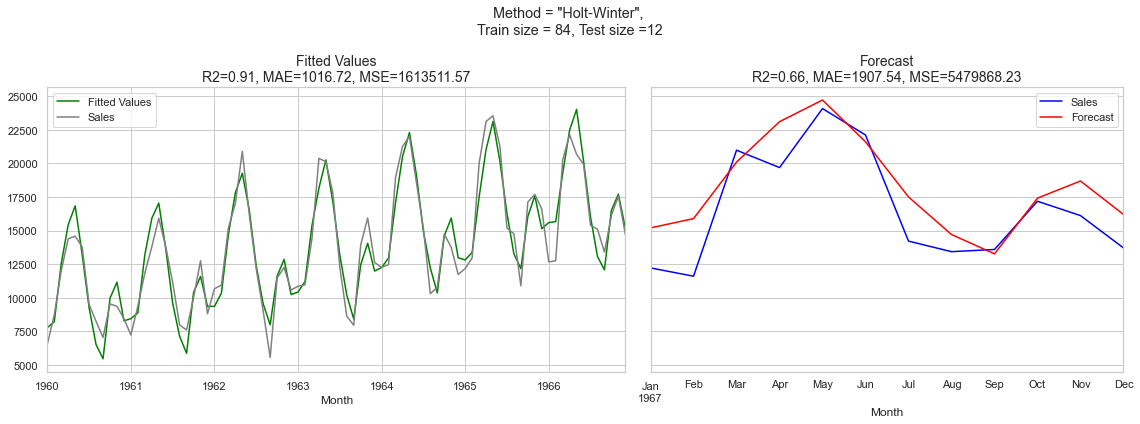

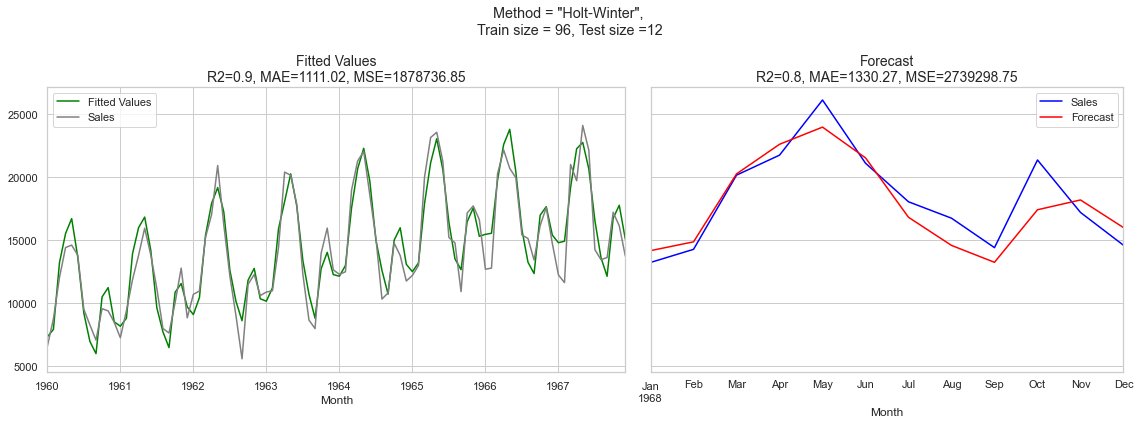

In [189]:
r2_list = []
mae_list = []

for i in range(n_splits,0,-1):
        
    idx = size - i*test_size
    train = df[0:idx]
    test = df[idx:idx+test_size]
    rest = df[idx+test_size:]

    holt_winter_mod=ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
    holt_winter_mod_values = holt_winter_mod.fittedvalues
    preds = holt_winter_mod.forecast(12)
    
    r2 = r2_score(test,preds) 
    mae = mean_absolute_error(test, preds)
    
    plot(train, test,holt_winter_mod_values, preds, methodname='Holt-Winter')
    plt.suptitle(f'Method = "Holt-Winter", \nTrain size = {len(train)}, Test size ={len(test)}')
    
    r2_list.append(r2)
    mae_list.append(mae)

In [190]:
r2_list

[0.7588684415754048,
 0.34335800991855603,
 0.6589743134313016,
 0.804557492945982]

In [191]:
mae_list

[1657.387410153064, 2234.9108467223873, 1907.5387817991962, 1330.2744865514362]

In [192]:
print(f'By Cross-Validation the average metrics values:\nr2-error = {np.mean(r2_list):.2f}\nmae = {np.mean(mae_list):.2f}')

By Cross-Validation the average metrics values:
r2-error = 0.64
mae = 1782.53
